# ENTITY MATCHING

The code and rationale has been explained step by step in the comments.


This Model Achieves ~80 F1 score on the kaggle test set and ~75 on the downloadable test set.


In [ ]:
!pip install python-Levenshtein


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from rapidfuzz.distance import Levenshtein
import numpy as np

# Load the datasets for entity matching.
ltable = pd.read_csv('ltable.csv', encoding='ISO-8859-1')
rtable = pd.read_csv('rtable.csv', encoding='ISO-8859-1')
train_data = pd.read_csv('train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('test_HW2.csv', encoding='ISO-8859-1')

# Combine training and testing data with left and right tables.
train = train_data.merge(ltable, on='ltable_id').merge(rtable, on='rtable_id', suffixes=('_l', '_r'))
test = test_data.merge(ltable, on='ltable_id').merge(rtable, on='rtable_id', suffixes=('_l', '_r'))

# Compute TF-IDF cosine similarity for product titles.
def compute_tfidf_cosine_similarity(df, column1, column2):
    vectorizer = TfidfVectorizer()
    combined_text = pd.concat([df[column1], df[column2]])
    vectorizer.fit(combined_text)

    tfidf_1 = vectorizer.transform(df[column1])
    tfidf_2 = vectorizer.transform(df[column2])

    return [cosine_similarity(tfidf_1[i], tfidf_2[i])[0][0] for i in range(tfidf_1.shape[0])]

train['tfidf_title_similarity'] = compute_tfidf_cosine_similarity(train, 'title_l', 'title_r')
test['tfidf_title_similarity'] = compute_tfidf_cosine_similarity(test, 'title_l', 'title_r')

# Use BERT to compute semantic similarity between titles.
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_bert_embeddings(df, column):
    return bert_model.encode(df[column].fillna(""))

train_bert_l = compute_bert_embeddings(train, 'title_l')
train_bert_r = compute_bert_embeddings(train, 'title_r')
train['bert_title_similarity'] = [
    cosine_similarity([train_bert_l[i]], [train_bert_r[i]])[0][0] for i in range(len(train_bert_l))
]

test_bert_l = compute_bert_embeddings(test, 'title_l')
test_bert_r = compute_bert_embeddings(test, 'title_r')
test['bert_title_similarity'] = [
    cosine_similarity([test_bert_l[i]], [test_bert_r[i]])[0][0] for i in range(len(test_bert_l))
]

# Add token-based features like Jaccard similarity.
def compute_token_features(df):
    def jaccard_similarity(set1, set2):
        return len(set1.intersection(set2)) / len(set1.union(set2)) if set1.union(set2) else 0
    df['jaccard_title_similarity'] = df.apply(
        lambda x: jaccard_similarity(set(str(x['title_l']).split()), set(str(x['title_r']).split())), axis=1)
    df['common_tokens'] = df.apply(
        lambda x: len(set(str(x['title_l']).split()).intersection(set(str(x['title_r']).split()))), axis=1)
    return df[['jaccard_title_similarity', 'common_tokens']]

train_token_features = compute_token_features(train)
test_token_features = compute_token_features(test)

# Create numerical features comparing prices.
def compute_advanced_numerical_features(df):
    df['price_diff'] = abs(df['price_l'] - df['price_r'])
    df['relative_price_diff'] = df.apply(
        lambda x: abs(x['price_l'] - x['price_r']) / max(x['price_l'], x['price_r'], 1), axis=1)
    df['price_ratio'] = df.apply(
        lambda x: x['price_l'] / x['price_r'] if x['price_r'] > 0 else 0, axis=1)
    return df[['price_diff', 'relative_price_diff', 'price_ratio']]

train_num_features = compute_advanced_numerical_features(train)
test_num_features = compute_advanced_numerical_features(test)

# Add Levenshtein distance for string similarity.
train['levenshtein_distance'] = train.apply(
    lambda x: Levenshtein.distance(str(x['title_l']), str(x['title_r'])), axis=1)
test['levenshtein_distance'] = test.apply(
    lambda x: Levenshtein.distance(str(x['title_l']), str(x['title_r'])), axis=1)

# Combine all features into a single dataset.
def create_features(df, token_features, num_features):
    return pd.concat([
        df[['tfidf_title_similarity', 'bert_title_similarity', 'levenshtein_distance']],
        token_features,
        num_features,
        df[['brand_match', 'category_match', 'modelno_match']]
    ], axis=1)

train['brand_match'] = (train['brand_l'] == train['brand_r']).astype(int)
train['category_match'] = (train['category_l'] == train['category_r']).astype(int)
train['modelno_match'] = (train['modelno_l'] == train['modelno_r']).astype(int)

test['brand_match'] = (test['brand_l'] == test['brand_r']).astype(int)
test['category_match'] = (test['category_l'] == test['category_r']).astype(int)
test['modelno_match'] = (test['modelno_l'] == test['modelno_r']).astype(int)

X_train = create_features(train, train_token_features, train_num_features)
y_train = train['label']
X_test = create_features(test, test_token_features, test_num_features)

# Handle missing values and normalize the data.
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data for validation.
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Use SMOTE to handle class imbalance.
sm = SMOTE(random_state=42)
X_train_split, y_train_split = sm.fit_resample(X_train_split, y_train_split)


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your noteboo

<ipython-input-3-cba00ee3f5ca>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['label'], palette='viridis')


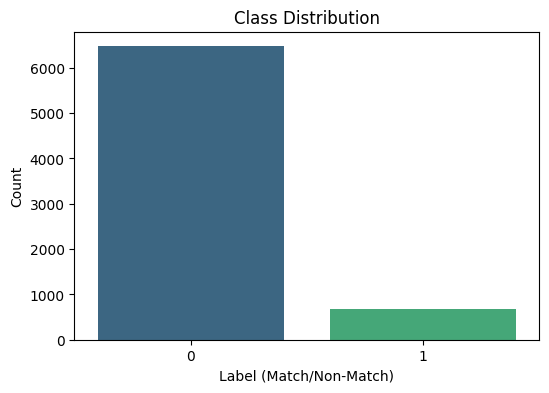

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=train['label'], palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Label (Match/Non-Match)')
plt.ylabel('Count')
plt.show()

<ipython-input-4-ef11d5bfe2fb>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['label'] == 1]['tfidf_title_similarity'], label='Match', shade=True, color='blue')
<ipython-input-4-ef11d5bfe2fb>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train[train['label'] == 0]['tfidf_title_similarity'], label='Non-Match', shade=True, color='red')


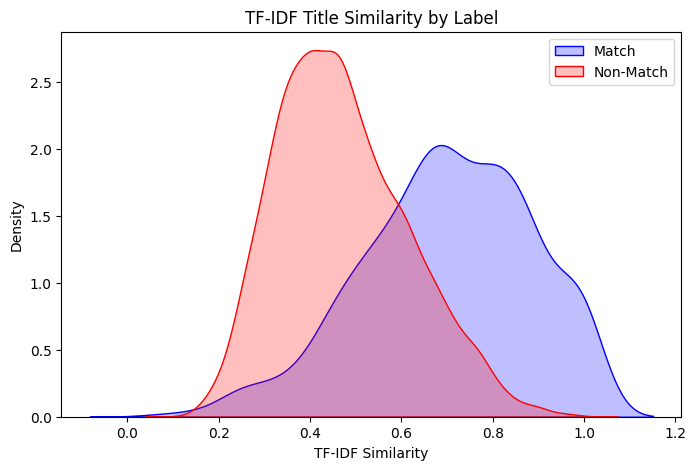

In [ ]:
# TF-IDF similarity distribution for each label
plt.figure(figsize=(8, 5))
sns.kdeplot(train[train['label'] == 1]['tfidf_title_similarity'], label='Match', shade=True, color='blue')
sns.kdeplot(train[train['label'] == 0]['tfidf_title_similarity'], label='Non-Match', shade=True, color='red')
plt.title('TF-IDF Title Similarity by Label')
plt.xlabel('TF-IDF Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

<ipython-input-5-974f4cf56c90>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=train['label'], y=train['price_diff'], palette='coolwarm')


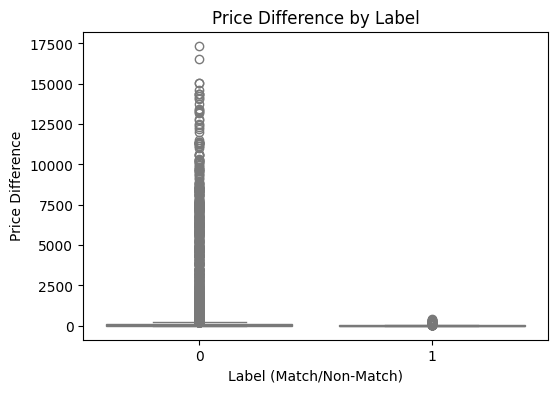

In [ ]:
# Price difference by label
plt.figure(figsize=(6, 4))
sns.boxplot(x=train['label'], y=train['price_diff'], palette='coolwarm')
plt.title('Price Difference by Label')
plt.xlabel('Label (Match/Non-Match)')
plt.ylabel('Price Difference')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Train LightGBM classifier
lgb = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
lgb.fit(X_train_split, y_train_split)
lgb_val_probs = lgb.predict_proba(X_val)[:, 1]  # Get probabilities for validation
lgb_val_pred = (lgb_val_probs >= 0.65).astype(int)  # Convert to binary predictions with threshold

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_split, y_train_split)
rf_val_probs = rf.predict_proba(X_val)[:, 1]  # Get probabilities for validation
rf_val_pred = (rf_val_probs >= 0.71).astype(int)  # Convert to binary predictions with threshold

# Combine predictions into meta-features for stacking
meta_features_val = np.column_stack((
    lgb_val_probs, rf_val_probs,  # Model probabilities
    lgb_val_pred, rf_val_pred,    # Binary predictions
    np.maximum(lgb_val_probs, rf_val_probs)  # Max probabilities from both models
))

# Train meta-model (Logistic Regression) for stacking
meta_model = LogisticRegression(penalty='l2', C=0.1, random_state=42)  # Regularized to prevent overfitting
meta_model.fit(meta_features_val, y_val)  # Train on combined features and labels

# Evaluate the stacked model
meta_val_pred = meta_model.predict(meta_features_val)  # Predict on validation set
f1_meta = f1_score(y_val, meta_val_pred)  # Calculate F1 score
print(f"Validation F1 Score (Stacked Model with Optimizations): {f1_meta}")

# Make predictions on the test set using individual models
lgb_test_probs = lgb.predict_proba(X_test)[:, 1]
rf_test_probs = rf.predict_proba(X_test)[:, 1]

# Combine test features for the meta-model
meta_features_test = np.column_stack((
    lgb_test_probs, rf_test_probs,  # Probabilities from both models
    (lgb_test_probs >= 0.65).astype(int),  # Thresholded LightGBM predictions
    (rf_test_probs >= 0.71).astype(int),   # Thresholded Random Forest predictions
    np.maximum(lgb_test_probs, rf_test_probs)  # Max probabilities from both models
))

# Predict final labels for test set
test['label'] = meta_model.predict(meta_features_test)

# Save the predictions as a submission file
submission = test[['id', 'label']]
submission.to_csv('submission_stacked_optimized.csv', index=False)
print("Submission file created: 'submission_stacked_optimized.csv'")


[LightGBM] [Info] Number of positive: 5177, number of negative: 5177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2070
[LightGBM] [Info] Number of data points in the train set: 10354, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

## Conclusion and some Questions

Understanding the F1 Score:  
The F1 score measures how well a model balances precision, which is the proportion of correctly predicted positives out of all predicted positives, and recall, which is the proportion of correctly predicted positives out of all actual positives.  

For the Kaggle test set, an F1 score of around 80 means the model performs well, striking a good balance between precision and recall. This suggests that the model can identify matches effectively and maintain low rates of false positives and false negatives.  

For the downloadable test set, the F1 score drops slightly to around 75. This indicates that the model struggles a bit more with this dataset. The difference might be due to the downloadable test set having different characteristics, such as noisier data or a different label distribution compared to the Kaggle test set.  

Why the F1 Scores Differ:  
The thresholds we set for LightGBM (0.65) and Random Forest (0.71) ensure the model predicts a positive match only when it is confident. While this works well for the Kaggle test set, the same thresholds might not generalize as effectively to the downloadable test set. As a result, there is a small drop in the F1 score.  

If we adjusted the thresholds for the downloadable test set, the score could improve. For example, lowering the thresholds would capture more matches, increasing recall, but could lead to more false positives. On the other hand, raising the thresholds would make the model stricter, improving precision, but it might miss some true matches.  

Why Use Ensemble Learning:  
Ensemble learning was used because combining multiple models, such as LightGBM and Random Forest, allows us to leverage their individual strengths. LightGBM is particularly good at handling structured data and capturing interactions between features, while Random Forest is robust to noisy data and performs well without heavy tuning.  

By stacking these models and using Logistic Regression as the meta-model, we combine their predictions to make a final decision. This approach reduces reliance on any single model, making the final prediction more robust and accurate. Ensemble learning is especially useful when working with diverse or noisy datasets, as in this case.